<a href="https://colab.research.google.com/github/bnarath/TF_Developer/blob/main/Transfer_Learning_with_TF_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

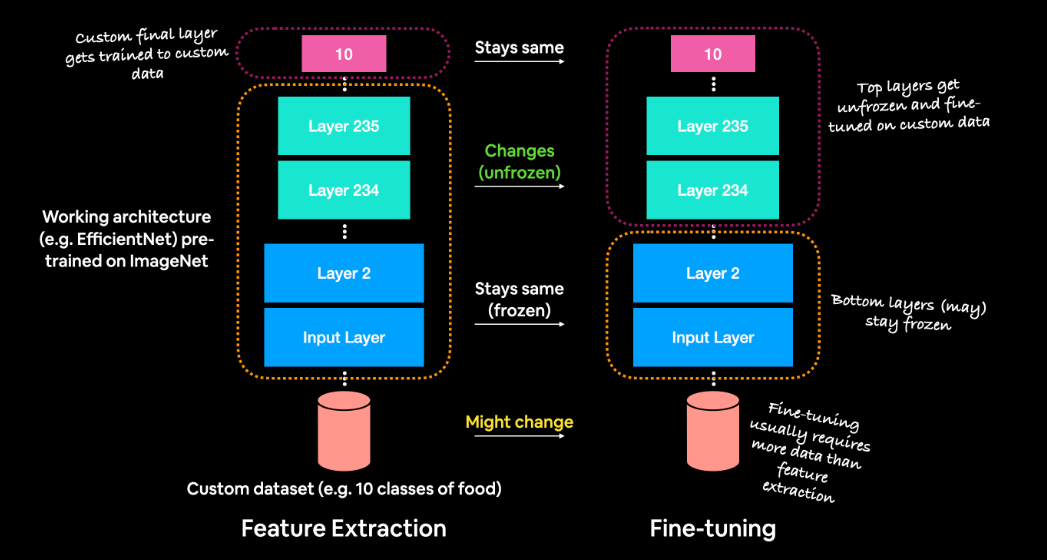



Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.


# Topics covered

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard




# Fine tune the prebuilt model in tf.keras.applications using own dataset of 10 food classes

## Download Data
- Data as train test folders
- 10 food items
- train 75 each
- test 250 each


## Dataloader
we use `tensorflow.keras.preprocessing.image_dataset_from_directory` instead of using `tensorflow.keras.preprocessing.image.ImageDataGenerator.flow_from_directory` because this new method returns `tf.data.Dataset` which is faster than the former

```
import tensorflow as tf
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode = "rgb",
    shuffle=True
)


test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode = "rgb",
    shuffle=False
)

```

## Inspect data
tf.data.Dataset.take(n) takes n batches of data

```
for images, labels in train_data_10_percent.take(1):
  print(images.shape, labels.shape)
  print(images[0].shape, labels[0].shape)
  print(images[0])
  print(labels[0])
```

## Build model using tf.keras.applications as base model and keras functional API

Keras applications are prebuild computer vision architectures trained on imagenet stored with trained weights

```
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                  weights='imagenet'
                                                  )

base_model.trainable = False


#Create a whole model
inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3), name="input_layer")
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(10, activation='softmax', name="output_layer")(x)

model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_0.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_0 = model_0.fit(train_data_10_percent,
          epochs=5,
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data_10_percent,
          validation_steps=int(0.25*len(test_data_10_percent)),
          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])
```




## Build data augmentation into the model

### Advantages
  1. Augmentation happens on GPUs (faster compared to CPU)
  1. Using the same model => Using the same augmentation

### Cons
  1. `tf.keras.layers.experimental.preprocessing` might slightly change in future

  1. Update: It is now available at tf.keras.layers

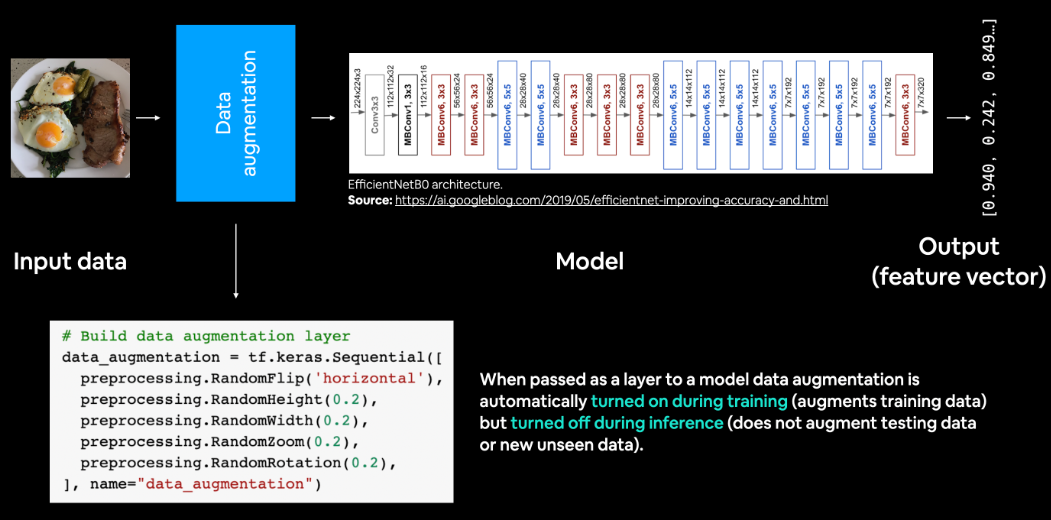


## Testing augmentation

```
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import PIL

target_class = random.choice(train_data_1_percent.class_names)
target_dir = os.path.join(train_dir_1_percent,target_class)
random_image = random.choice(os.listdir(target_dir))
random_image_path = os.path.join(target_dir, random_image)

img = mpimg.imread(random_image_path)


plt.figure()
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(emit=False);



augmented_image = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
```

## Build feature extraction model with augmentation

```
from tensorflow.keras.preprocessing import image_dataset_from_directory



# Create train and test dataset
train_data_10_percent = image_dataset_from_directory(train_dir_10_percent,
                             labels='inferred',
                             label_mode='categorical',
                             color_mode='rgb',
                             batch_size=BATCH_SIZE,
                             image_size=IMAGE_SIZE,
                             shuffle=True)


test_data = image_dataset_from_directory(test_dir,
                             labels='inferred',
                             label_mode='categorical',
                             color_mode='rgb',
                             batch_size=BATCH_SIZE,
                             image_size=IMAGE_SIZE,
                             shuffle=False)

train_data_10_percent , test_data


# load base model
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False,
                            weights='imagenet',
                            input_shape=(*IMAGE_SIZE, 3),
                           )

base_model.trainable = False

from tensorflow.keras.layers import (RandomFlip, 
                                     RandomHeight, 
                                     RandomRotation, 
                                     RandomWidth, 
                                     RandomZoom)

from tensorflow.keras import Sequential

# build augmentation preprocessing layers
data_augmentation = Sequential([
    RandomFlip(mode='horizontal'),
    RandomHeight(factor=0.2),
    RandomWidth(factor=0.2),
    RandomZoom(height_factor=0.2, width_factor=0.2),
    RandomRotation(factor=0.2)
], name="augmentation")


#build full model
inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3), name="input")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names), activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)
model.summary()

model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor='val_loss',
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         verbose=1,
                                                         save_freq='epoch') #every epoch



history_2 = model_2.fit(train_data_10_percent,
            validation_data=test_data,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_steps=int(0.25*len(test_data)),
            callbacks=[checkpoint_callback, create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])
            
```


### Load Model weights into the model

```
model_2.load_weights(checkpoint_path)
model_2.evaluate(test_data)
import numpy as np
np.isclose(np.array([0.16632886230945587, 0.8252000212669373]), np.array([0.16632886230945587, 0.8252000212669373]))
```


### Visualization of comparing two models
```
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
```

### Tesnorboard upload

```
!tensorboard dev upload --logdir transfer_learning \
                        --name "Transfer learning experiments" \
                        --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
                        --one_shot
!tensorboard dev list
!tensorboard dev delete --experiment_id cKwfMh0pTBOYEtePNuNmdw
```

In [1]:
!nvidia-smi

Tue Feb 14 20:18:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Helper functions

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 
from helper_functions import plot_loss_curves, create_tensorboard_callback, unzip_data, walk_through_dir

--2023-02-14 20:18:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-14 20:18:03 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Fine tune the prebuilt model in tf.keras.applications using own dataset of 10 food classes

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-14 20:18:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   111MB/s    in 1.5s    

2023-02-14 20:18:12 (111 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data('10_food_classes_10_percent.zip')

In [5]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Prepare dataloader

This time we use `tensorflow.keras.preprocessing.image_dataset_from_directory` instead of using `tensorflow.keras.preprocessing.image.ImageDataGenerator.flow_from_directory` because this new method returns `tf.data.Dataset` which is faster than the former


In [6]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32


train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode = "rgb",
    shuffle=True
)


test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode = "rgb",
    shuffle=False
)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent, test_data_10_percent

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

In [9]:
train_data_10_percent.class_names==test_data_10_percent.class_names
CLASS_NAMES = train_data_10_percent.class_names

In [10]:
for images, labels in train_data_10_percent.take(1):
  print(images.shape, labels.shape)
  print(images[0].shape, labels[0].shape)
  print(images[0])
  print(labels[0])
  

(32, 224, 224, 3) (32, 10)
(224, 224, 3) (10,)
tf.Tensor(
[[[114.85204   103.92347    88.28062  ]
  [108.20918    99.87245    84.54082  ]
  [111.872444  103.36735    89.35714  ]
  ...
  [  6.428528    8.          7.214264 ]
  [  6.          8.          7.       ]
  [  7.          9.          8.       ]]

 [[108.18878   100.42347    87.4949   ]
  [109.65306   103.66326    89.94388  ]
  [110.408165  104.551025   92.65307  ]
  ...
  [  7.214264    8.785736    8.       ]
  [  6.1377673   8.137767    7.1377673]
  [  7.          9.          8.       ]]

 [[108.841835  105.69898    93.97959  ]
  [124.85204   121.63776   112.20918  ]
  [186.09692   182.88264   173.88264  ]
  ...
  [  7.831628    8.168372    8.       ]
  [  7.          9.          8.       ]
  [  7.          9.          8.       ]]

 ...

 [[113.08684   106.08684    90.08684  ]
  [116.775536  109.775536   93.775536 ]
  [113.74993   106.74993    90.74993  ]
  ...
  [ 82.525314   78.525314   66.525314 ]
  [ 82.14802    78.14802  

## Build model using tf.keras.applications

In [11]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                  weights='imagenet'
                                                  )

base_model.trainable = False


#Create a whole model
inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3), name="input_layer")
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(10, activation='softmax', name="output_layer")(x)

model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_0.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_0 = model_0.fit(train_data_10_percent,
          epochs=5,
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data_10_percent,
          validation_steps=int(0.25*len(test_data_10_percent)),
          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])



16705208/16705208 [==============================] - 0s 0us/step


Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230214-201833
Epoch 1/5
24/24 [==============================] - 20s 202ms/step - loss: 1.8542 - accuracy: 0.4467 - val_loss: 1.3797 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 5s 177ms/step - loss: 1.0931 - accuracy: 0.7747 - val_loss: 0.9818 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - 5s 179ms/step - loss: 0.7822 - accuracy: 0.8440 - val_loss: 0.7688 - val_accuracy: 0.8141
Epoch 4/5
24/24 [==============================] - 5s 176ms/step - loss: 0.6362 - accuracy: 0.8640 - val_loss: 0.7139 - val_accuracy: 0.8125
Epoch 5/5
24/24 [==============================] - 4s 155ms/step - loss: 0.5494 - accuracy: 0.8760 - val_loss: 0.6387 - val_accuracy: 0.8306


In [12]:
for layer_number, layer in enumerate(model_0.layers):
  print(layer_number, layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 output_layer


In [13]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [14]:

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


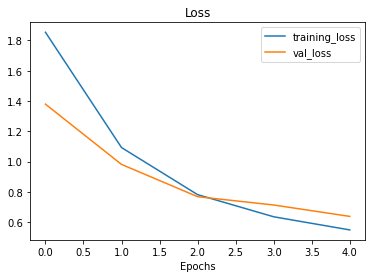

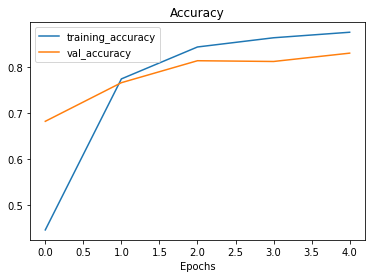

In [16]:
plot_loss_curves(history_0)

## Inspecting tf.keras.layers.GlobalAveragePooling2D()

In [17]:
input_shape = (1, 4, 4, 3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [18]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [19]:
tf.reduce_mean(input_tensor, axis=[1,2]) == global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

# Running a series of transfer learning experiments

## model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

In [20]:

# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-02-14 20:19:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   154MB/s    in 0.8s    

2023-02-14 20:19:15 (154 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [22]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           labels="inferred",
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE,
                                                                           shuffle=True)


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                labels="inferred",
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Build data augmentation into the model

### Advantages
  1. Augmentation happens on GPUs (faster compared to CPU)
  1. Using the same model => Using the same augmentation

### Cons
  1. `tf.keras.layers.experimental.preprocessing` might slightly change in future

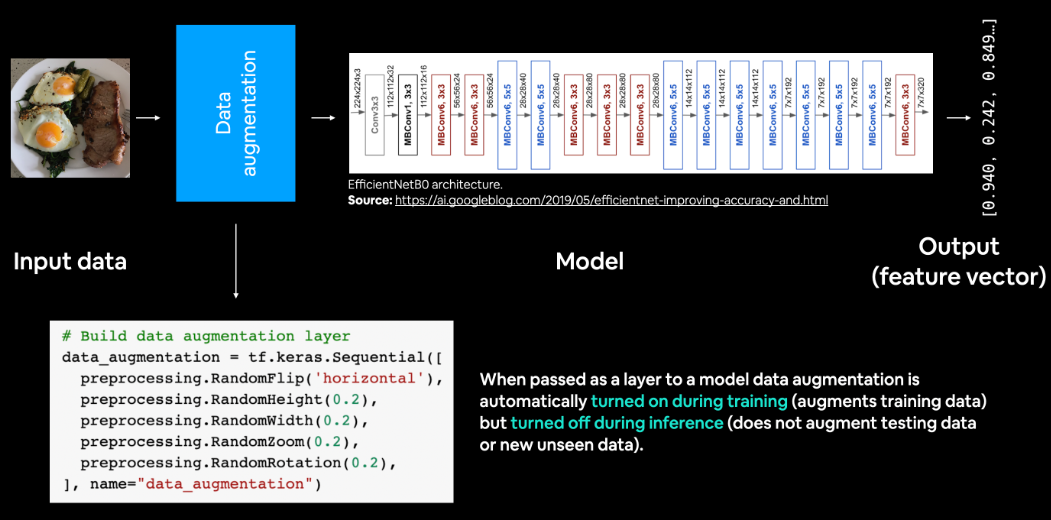


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom, Rescaling

data_augmentation = keras.Sequential(
    [
        RandomFlip(mode="horizontal"),
        RandomRotation(factor=0.2), #[-20% * 2pi, 20% * 2pi]
        RandomZoom(height_factor = 0.2, width_factor = 0.2), #[-20%, 20%] for both height and width
        RandomHeight(factor=0.2),
        RandomWidth(factor=0.2),
        # Rescaling(scale=1./255)
    ], name="data_augmentation"
)

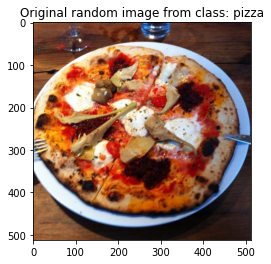

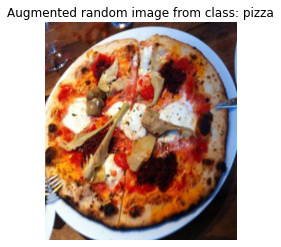

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import PIL

target_class = random.choice(train_data_1_percent.class_names)
target_dir = os.path.join(train_dir_1_percent,target_class)
random_image = random.choice(os.listdir(target_dir))
random_image_path = os.path.join(target_dir, random_image)

img = mpimg.imread(random_image_path)
# PIL.Image.open(random_image_path)

plt.figure()
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(emit=False);


#Augmented image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [25]:
augmented_image.shape

TensorShape([1, 540, 476, 3])

In [26]:
img.shape

(512, 512, 3)

# Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom



IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           labels="inferred",
                                                                           label_mode="categorical",
                                                                           image_size=IMAGE_SHAPE,
                                                                           batch_size=BATCH_SIZE,
                                                                           shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                labels="inferred",
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)




data_augmentation = keras.Sequential([
    RandomFlip(mode="horizontal"),
    RandomRotation(factor=0.2),
    RandomZoom(height_factor=0.2, width_factor=0.2),
    RandomHeight(factor=0.2),
    RandomWidth(factor=0.2)
], name="data_augmentation")


inputs = Input(shape=(*IMAGE_SIZE, 3), name="input_layer")

x = data_augmentation(inputs)

base_model = keras.applications.EfficientNetB0(include_top=False,
                                  weights='imagenet'
                                  )
base_model.trainable = False

x = base_model(x, training=False) #This is for batch norm layers which has to be frozen not to learn moving averages of mean and variance

x = GlobalAveragePooling2D(data_format='channels_last', keepdims=False, name="global_average_pooling_layer")(x)

outputs = Dense(units=10, activation='softmax', name="output_layer")(x)

model_1 = keras.Model(inputs=inputs, outputs=outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        validation_data=test_data,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])







Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230214-201925
Epoch 1/5


3/3 [==============================] - 15s 2s/step - loss: 2.3186 - accuracy: 0.1571 - val_loss: 2.4046 - val_accuracy: 0.0526
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.0560 - accuracy: 0.2571 - val_loss: 2.2255 - val_accuracy: 0.1283
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8765 - accuracy: 0.3571 - val_loss: 2.0987 - val_accuracy: 0.2385
Epoch 4/5
3/3 [==============================] - 3s 924ms/step - loss: 1.6904 - accuracy: 0.4857 - val_loss: 2.0119 - val_accuracy: 0.3010
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5427 - accuracy: 0.6857 - val_loss: 1.9404 - val_accuracy: 0.3536


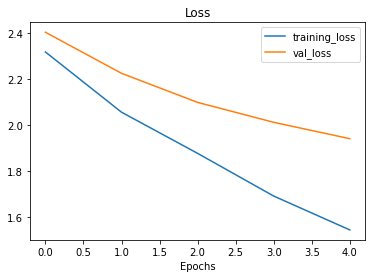

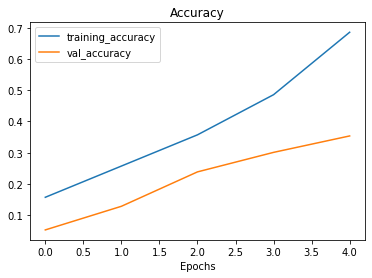

In [28]:
plot_loss_curves(history_1)

In [29]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 84ms/step - loss: 1.7826 - accuracy: 0.4628


[1.782566785812378, 0.462799996137619]

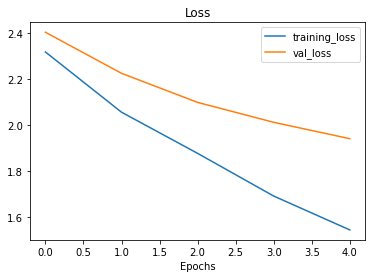

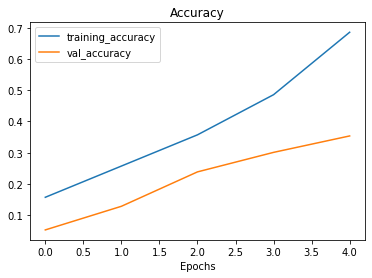

In [31]:
plot_loss_curves(history_1)

# Model 2: Feature extraction transfer learning on 10% of the data with data augmentation

In [32]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [33]:
from tensorflow.keras.preprocessing import image_dataset_from_directory



# Create train and test dataset
train_data_10_percent = image_dataset_from_directory(train_dir_10_percent,
                             labels='inferred',
                             label_mode='categorical',
                             color_mode='rgb',
                             batch_size=BATCH_SIZE,
                             image_size=IMAGE_SIZE,
                             shuffle=True)


test_data = image_dataset_from_directory(test_dir,
                             labels='inferred',
                             label_mode='categorical',
                             color_mode='rgb',
                             batch_size=BATCH_SIZE,
                             image_size=IMAGE_SIZE,
                             shuffle=False)

train_data_10_percent , test_data


# load base model
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False,
                            weights='imagenet',
                            input_shape=(*IMAGE_SIZE, 3),
                           )

base_model.trainable = False

from tensorflow.keras.layers import (RandomFlip, 
                                     RandomHeight, 
                                     RandomRotation, 
                                     RandomWidth, 
                                     RandomZoom)

from tensorflow.keras import Sequential

# build augmentation preprocessing layers
data_augmentation = Sequential([
    RandomFlip(mode='horizontal'),
    RandomHeight(factor=0.2),
    RandomWidth(factor=0.2),
    RandomZoom(height_factor=0.2, width_factor=0.2),
    RandomRotation(factor=0.2)
], name="augmentation")


#build full model
inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3), name="input")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names), activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.summary()

model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor='val_loss',
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         verbose=1,
                                                         save_freq='epoch') #every epoch



history_2 = model_2.fit(train_data_10_percent,
            validation_data=test_data,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_steps=int(0.25*len(test_data)),
            callbacks=[checkpoint_callback, create_tensorboard_callback("transfer_learning", "10_percent_data_aug")])
            

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230214-202010
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.2427
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 718ms/step - loss: 0.4237 - accuracy: 0.2427 - val_loss: 0.2976 - val_accuracy: 0.3882
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.5573
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 553ms/step - loss: 0.2725 - accuracy: 0.5573 - val_loss: 0.2524 - val_accuracy: 0.5970
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.7013
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 536ms/step - loss: 0.2283 - accuracy: 0.7013 - val_loss: 0.2182 - val_accuracy: 0.6842
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.7440
Epoch

In [34]:
model_2.evaluate(test_data)
                                                         



79/79 [==============================] - 6s 70ms/step - loss: 0.1631 - accuracy: 0.8364


[0.1630547046661377, 0.8363999724388123]

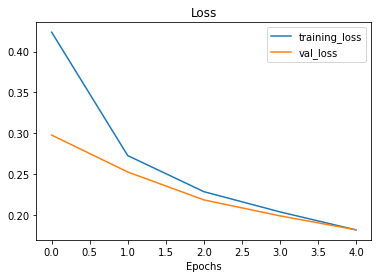

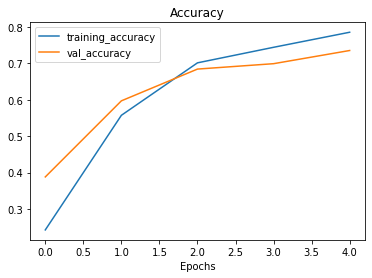

In [35]:

# Plot model loss curves
plot_loss_curves(history_2)

In [36]:
model_2.load_weights(checkpoint_path)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 78ms/step - loss: 0.1631 - accuracy: 0.8364


[0.1630547046661377, 0.8363999724388123]

In [37]:
import numpy as np
np.isclose(np.array([0.16632886230945587, 0.8252000212669373]), np.array([0.16632886230945587, 0.8252000212669373]))

array([ True,  True])

## Model 3: Fine tuning an existing model with 10% data

In [38]:
model_2.layers

In [39]:
for layer in model_2.layers:
    print(f"{layer.name}, trainable: {layer.trainable}")

input, trainable: True
augmentation, trainable: True
efficientnetb0, trainable: False
global_average_pooling2d_1, trainable: True
dense, trainable: True


In [40]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

In [41]:
model_2.layers[2].trainable_variables

[]

In [42]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [43]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [44]:
model_2.layers[2].trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [45]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [46]:

print(len(model_2.trainable_variables))
     

12


In [47]:
fine_tune_epochs = 10
checkpoint_path = "ten_percent_fine_tuning_model_checkpoints_weights/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_loss',
                                                         verbose=1,
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         save_freq='epoch')
                                                     
                                                     

In [48]:
history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        verbose=1,
                        validation_data=test_data,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug_fine_tuning"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug_fine_tuning/20230214-202153
Epoch 1/10


24/24 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.8040
Epoch 1: val_loss improved from inf to 0.72116, saving model to ten_percent_fine_tuning_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 28s 675ms/step - loss: 0.7280 - accuracy: 0.8040 - val_loss: 0.7212 - val_accuracy: 0.7484
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.8347
Epoch 2: val_loss improved from 0.72116 to 0.67273, saving model to ten_percent_fine_tuning_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 482ms/step - loss: 0.5633 - accuracy: 0.8347 - val_loss: 0.6727 - val_accuracy: 0.7615
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8560
Epoch 3: val_loss improved from 0.67273 to 0.59398, saving model to ten_percent_fine_tuning_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 532ms/step - loss: 0.4

In [49]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 78ms/step - loss: 0.4126 - accuracy: 0.8616


[0.4125862717628479, 0.8615999817848206]

In [50]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
15
[0.24266666173934937, 0.5573333501815796, 0.7013333439826965, 0.7440000176429749, 0.7853333353996277, 0.8040000200271606, 0.8346666693687439, 0.8560000061988831, 0.8693333268165588, 0.874666690826416, 0.9106666445732117, 0.9120000004768372, 0.9106666445732117, 0.9226666688919067, 0.9306666851043701]


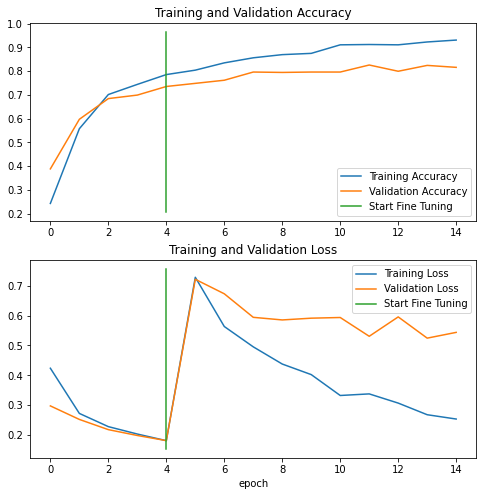

In [51]:
compare_historys(original_history=history_2, 
                 new_history=history_3, 
                 initial_epochs=5)

# Model 4: Fine-tuning an existing model with all the data

In [52]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

walk_through_dir("10_food_classes_all_data")

--2023-02-14 20:24:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   186MB/s    in 2.7s    

2023-02-14 20:24:22 (186 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_

In [53]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED=42


#model 2 architecture
def build_model(train_last_layers = 10, image_size=IMAGE_SIZE):
    # load base model
    from tensorflow.keras.applications import EfficientNetB0

    base_model = EfficientNetB0(include_top=False,
                                weights='imagenet',
                                input_shape=(*image_size, 3),
                               )

    base_model.trainable = True
    for layer in base_model.layers[:-train_last_layers]:
        layer.trainable=False
        

    from tensorflow.keras.layers import (RandomFlip, 
                                         RandomHeight, 
                                         RandomRotation, 
                                         RandomWidth, 
                                         RandomZoom)

    from tensorflow.keras import Sequential

    # build augmentation preprocessing layers
    data_augmentation = Sequential([
        RandomFlip(mode='horizontal'),
        RandomHeight(factor=0.2),
        RandomWidth(factor=0.2),
        RandomZoom(height_factor=0.2, width_factor=0.2),
        RandomRotation(factor=0.2)
    ], name="augmentation")


    #build full model
    inputs = tf.keras.layers.Input(shape=(*image_size, 3), name="input")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)
    outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Data loader
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                 labels='inferred',
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE,
                                                                 shuffle=True,
                                                                 seed=SEED)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                 labels='inferred',
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE,
                                                                 shuffle=False)

# model 2 loaded from checkpont of model 2 (base model feature extraction, 10% data)
model_2.evaluate(test_data)

model = build_model()
model.load_weights("ten_percent_model_checkpoints_weights/checkpoint.ckpt")
# compile and fit
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

model.evaluate(test_data)




Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
79/79 [==============================] - 6s 69ms/step - loss: 0.4126 - accuracy: 0.8616


79/79 [==============================] - 8s 68ms/step - loss: 0.1631 - accuracy: 0.8364


[0.1630547046661377, 0.8363999724388123]

In [54]:
checkpoint_path = "all_data_10_layers_fine_tuning/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_loss',
                                                         verbose=1,
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         save_freq='epoch')

In [55]:
fine_tune_epochs = 10

history_4 = model.fit(train_data,
                      validation_data=test_data,
                      epochs=fine_tune_epochs,
                      steps_per_epoch=len(train_data),
                      validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10"),
                                 checkpoint_callback])



Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230214-202448


Epoch 1/10


235/235 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.7965
Epoch 1: val_loss improved from inf to 0.06462, saving model to all_data_10_layers_fine_tuning/checkpoint.ckpt
235/235 [==============================] - 107s 403ms/step - loss: 0.1129 - accuracy: 0.7965 - val_loss: 0.0646 - val_accuracy: 0.8849
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.8609
Epoch 2: val_loss improved from 0.06462 to 0.04451, saving model to all_data_10_layers_fine_tuning/checkpoint.ckpt
235/235 [==============================] - 89s 377ms/step - loss: 0.0776 - accuracy: 0.8609 - val_loss: 0.0445 - val_accuracy: 0.9309
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.8837
Epoch 3: val_loss did not improve from 0.04451
235/235 [==============================] - 86s 365ms/step - loss: 0.0671 - accuracy: 0.8837 - val_loss: 0.0488 - val_accuracy: 0.9161
Epoch 4/10
235/235 [===========================

In [56]:
model.evaluate(test_data)ye

79/79 [==============================] - 7s 82ms/step - loss: 0.0583 - accuracy: 0.9164


[0.0583154559135437, 0.9164000153541565]

5
15
[0.24266666173934937, 0.5573333501815796, 0.7013333439826965, 0.7440000176429749, 0.7853333353996277, 0.7965333461761475, 0.8609333038330078, 0.883733332157135, 0.9061333537101746, 0.9246666431427002, 0.9330666661262512, 0.9421333074569702, 0.9484000205993652, 0.9508000016212463, 0.9633333086967468]


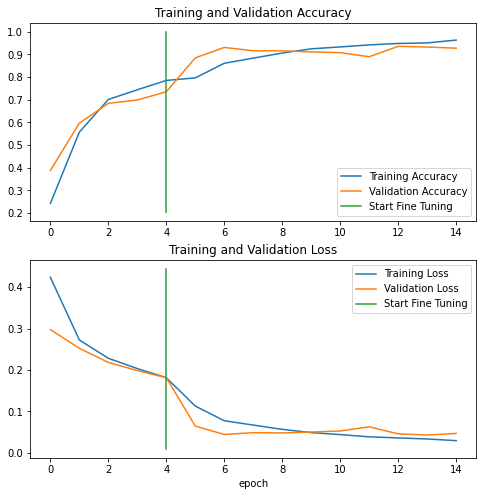

In [57]:
compare_historys(original_history=history_2,
                 new_history=history_4,
                 initial_epochs=5)
     

In [58]:
!tensorboard dev upload --logdir transfer_learning \
                        --name "Transfer learning experiments" \
                        --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
                        --one_shot

2023-02-14 20:40:49.830930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 20:40:49.831044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 20:40:49.831063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

transfer_learning

This TensorBoar

In [59]:
!tensorboard dev list

2023-02-14 20:46:59.732244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 20:46:59.732362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 20:46:59.732386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/cKwfMh0pTBOYEtePNuNmdw/
	Name                 Transfer learning experiments
	Description          A series of different transfer lea

In [60]:
!tensorboard dev delete --experiment_id cKwfMh0pTBOYEtePNuNmdw

2023-02-14 20:49:47.588907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 20:49:47.589009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 20:49:47.589027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Deleted experiment cKwfMh0pTBOYEtePNuNmdw.
